In this notebook, we will be building our model for the closed-world experiments to classify 95 monitored websites

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import psutil
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Extracting Data

To begin, we will first import the dataframes into this notebook. Run either 1 of these blocks

If you are using Google Colab, run this block

In [2]:
# 1 Use this with colab
#print("Loading datafile...")
#with open('datasets/extracted_features.pkl', 'rb') as f:
#    extracted_df = pickle.load(f)
#print ("Data loaded")

If you are using local, run this block

In [3]:
# 2 Use this for local (change the directory to where the extracted_features.pkl is stored on your local machine)
# Load the pickle file
print("Loading datafile...")
# change this directory to the directory where mon_standard.pkl is stored on your local machine
file_path = r'C:\EWHA\Term 2\Machine Learning\pro\neurotic_networkers\extracted_features.pkl' # Jordans local path
with open(file_path, 'rb') as f: # Path to extracted_features.pkl in Colab
    extracted_df = pickle.load(f)
print ("Data loaded")

Loading datafile...
Data loaded


In [4]:
extracted_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In this notebook, since we will only be dealing with the closed world experiments, we will first extract the relevant data from the dataframe

In [5]:
closed_world_df = extracted_df[extracted_df['label'] != -1]

In [6]:
closed_world_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
18995,94,8815,619,9434,0.934386,0.065614,3053.116218,4844.586430,43.91,0.004654
18996,94,9404,552,9956,0.944556,0.055444,3010.091146,4541.974638,15.60,0.001567
18997,94,9373,579,9952,0.941821,0.058179,3102.381602,4766.072539,14.93,0.001500
18998,94,9236,690,9926,0.930486,0.069514,3116.574388,5278.146377,19.91,0.002006


Next, we separate the features and the target. Target will be label which represents the label of the monitored websites. Features will be the remaining columns.

In [7]:
X_initial = closed_world_df.drop(columns=['label'])
y_initial = closed_world_df['label']

# Constructing Model with all features

Here, we construct a model using all of the features.

In [8]:
# Split data into training and testing sets
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(
    X_initial, y_initial, test_size=0.2, random_state=42
)

In [9]:
# Linear Regression Model with scaled data

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_X_initial_train = scaler.fit_transform(X_initial_train)
scaled_X_initial_test = scaler.transform(X_initial_test)

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(scaled_X_initial_train, y_initial_train)

# Calculate RAM usage
process = psutil.Process(os.getpid())

# Start timer
start_time = time.time()

# Make predictions on the test set
y_pred = lr_model.predict(scaled_X_initial_test)

# End timer
end_time = time.time()

# Calculate and print regression metrics
print("Mean Squared Error:", mean_squared_error(y_initial_test, y_pred))
print("R^2 Score:", r2_score(y_initial_test, y_pred))
print("Time to run: {:.2f} seconds".format(end_time - start_time))
print("Memory used: {:.2f} MB".format(process.memory_info().rss / 1024 ** 2))
print("Model R^2 Accuracy: {:.2f}%".format(r2_score(y_initial_test, y_pred) * 100))


Mean Squared Error: 710.6929603735165
R^2 Score: 0.029731476003219015
Time to run: 0.00 seconds
Memory used: 186.70 MB
Model R^2 Accuracy: 2.97%


In [10]:
# SVM Model with scaled data

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_X_initial_train = scaler.fit_transform(X_initial_train)
scaled_X_initial_test = scaler.transform(X_initial_test)

# Initialize the SVC model
SVM_model = SVC()

# Train the model
SVM_model.fit(scaled_X_initial_train, y_initial_train)

# Calculate RAM usage
process = psutil.Process(os.getpid())

# Start timer
start_time = time.time()

# Make predictions on the test set
y_pred = SVM_model.predict(scaled_X_initial_test)

# End timer
end_time = time.time()

# Print evaluation metrics
print("Time to run: {:.2f} seconds".format(end_time - start_time))
print("Memory used: {:.2f} MB".format(process.memory_info().rss / 1024 ** 2))
print("Model Accuracy: {:.2f}%".format(SVM_model.score(scaled_X_initial_test, y_initial_test) * 100))
print(classification_report(y_initial_test, y_pred, zero_division=1))

Time to run: 7.88 seconds
Memory used: 200.12 MB
Model Accuracy: 35.95%
              precision    recall  f1-score   support

           0       0.80      0.10      0.17        42
           1       1.00      0.00      0.00        42
           2       0.19      0.57      0.29        35
           3       0.25      0.14      0.18        29
           4       0.07      0.03      0.04        39
           5       0.58      0.24      0.34        45
           6       0.32      0.82      0.46        44
           7       0.11      0.19      0.14        36
           8       0.38      0.18      0.24        34
           9       0.18      0.42      0.25        31
          10       0.33      0.04      0.08        47
          11       0.48      0.40      0.44        35
          12       0.66      0.64      0.65        42
          13       1.00      0.00      0.00        40
          14       0.46      0.17      0.24        36
          15       0.18      0.37      0.24        35
         

In [11]:
# Initialize the model
clf_all_features = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, min_samples_split=2, max_features="sqrt", random_state=42)

# Train the model
clf_all_features.fit(X_initial_train, y_initial_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=42)

In [12]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the train set
y_initial_train_pred = clf_all_features.predict(X_initial_train)
# tracking end time
end_time = time.time()

time_taken_all_features_train = end_time - start_time
memory_used_all_features_train = process.memory_info().rss / (1024 * 1024)

In [13]:
# Print accuracy and other metrics
print("Memory used:", memory_used_all_features_train, "MB")
print("Time taken to predict:", time_taken_all_features_train, "seconds")
print("Model Accuracy:", accuracy_score(y_initial_train, y_initial_train_pred))
print(classification_report(y_initial_train, y_initial_train_pred))

Memory used: 220.73046875 MB
Time taken to predict: 0.45766115188598633 seconds
Model Accuracy: 0.49098684210526317
              precision    recall  f1-score   support

           0       0.89      0.20      0.33       158
           1       0.00      0.00      0.00       158
           2       0.57      0.78      0.66       165
           3       0.65      0.42      0.51       171
           4       0.67      0.34      0.45       161
           5       0.58      0.32      0.41       155
           6       0.35      0.92      0.50       156
           7       0.38      0.76      0.50       164
           8       0.63      0.30      0.41       166
           9       0.41      0.50      0.45       169
          10       0.55      0.31      0.40       153
          11       0.34      0.32      0.33       165
          12       0.71      0.68      0.69       158
          13       1.00      0.07      0.13       160
          14       0.66      0.37      0.47       164
          15       

c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_initial_test_pred = clf_all_features.predict(X_initial_test)
# tracking end time
end_time = time.time()

time_taken_all_features_test = end_time - start_time
memory_used_all_features_test = process.memory_info().rss / (1024 * 1024)

In [15]:
# Print accuracy and other metrics
print("Memory used:", memory_used_all_features_test, "MB")
print("Time taken to predict:", time_taken_all_features_test, "seconds")
print("Model Accuracy:", accuracy_score(y_initial_test, y_initial_test_pred))
print(classification_report(y_initial_test, y_initial_test_pred))

Memory used: 221.0234375 MB
Time taken to predict: 0.08843588829040527 seconds
Model Accuracy: 0.4478947368421053
              precision    recall  f1-score   support

           0       0.90      0.21      0.35        42
           1       0.00      0.00      0.00        42
           2       0.43      0.80      0.56        35
           3       0.35      0.28      0.31        29
           4       0.67      0.41      0.51        39
           5       0.52      0.24      0.33        45
           6       0.35      0.84      0.49        44
           7       0.28      0.56      0.37        36
           8       0.61      0.32      0.42        34
           9       0.22      0.42      0.29        31
          10       0.64      0.34      0.44        47
          11       0.33      0.40      0.36        35
          12       0.70      0.67      0.68        42
          13       0.00      0.00      0.00        40
          14       0.54      0.19      0.29        36
          15       0.

c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


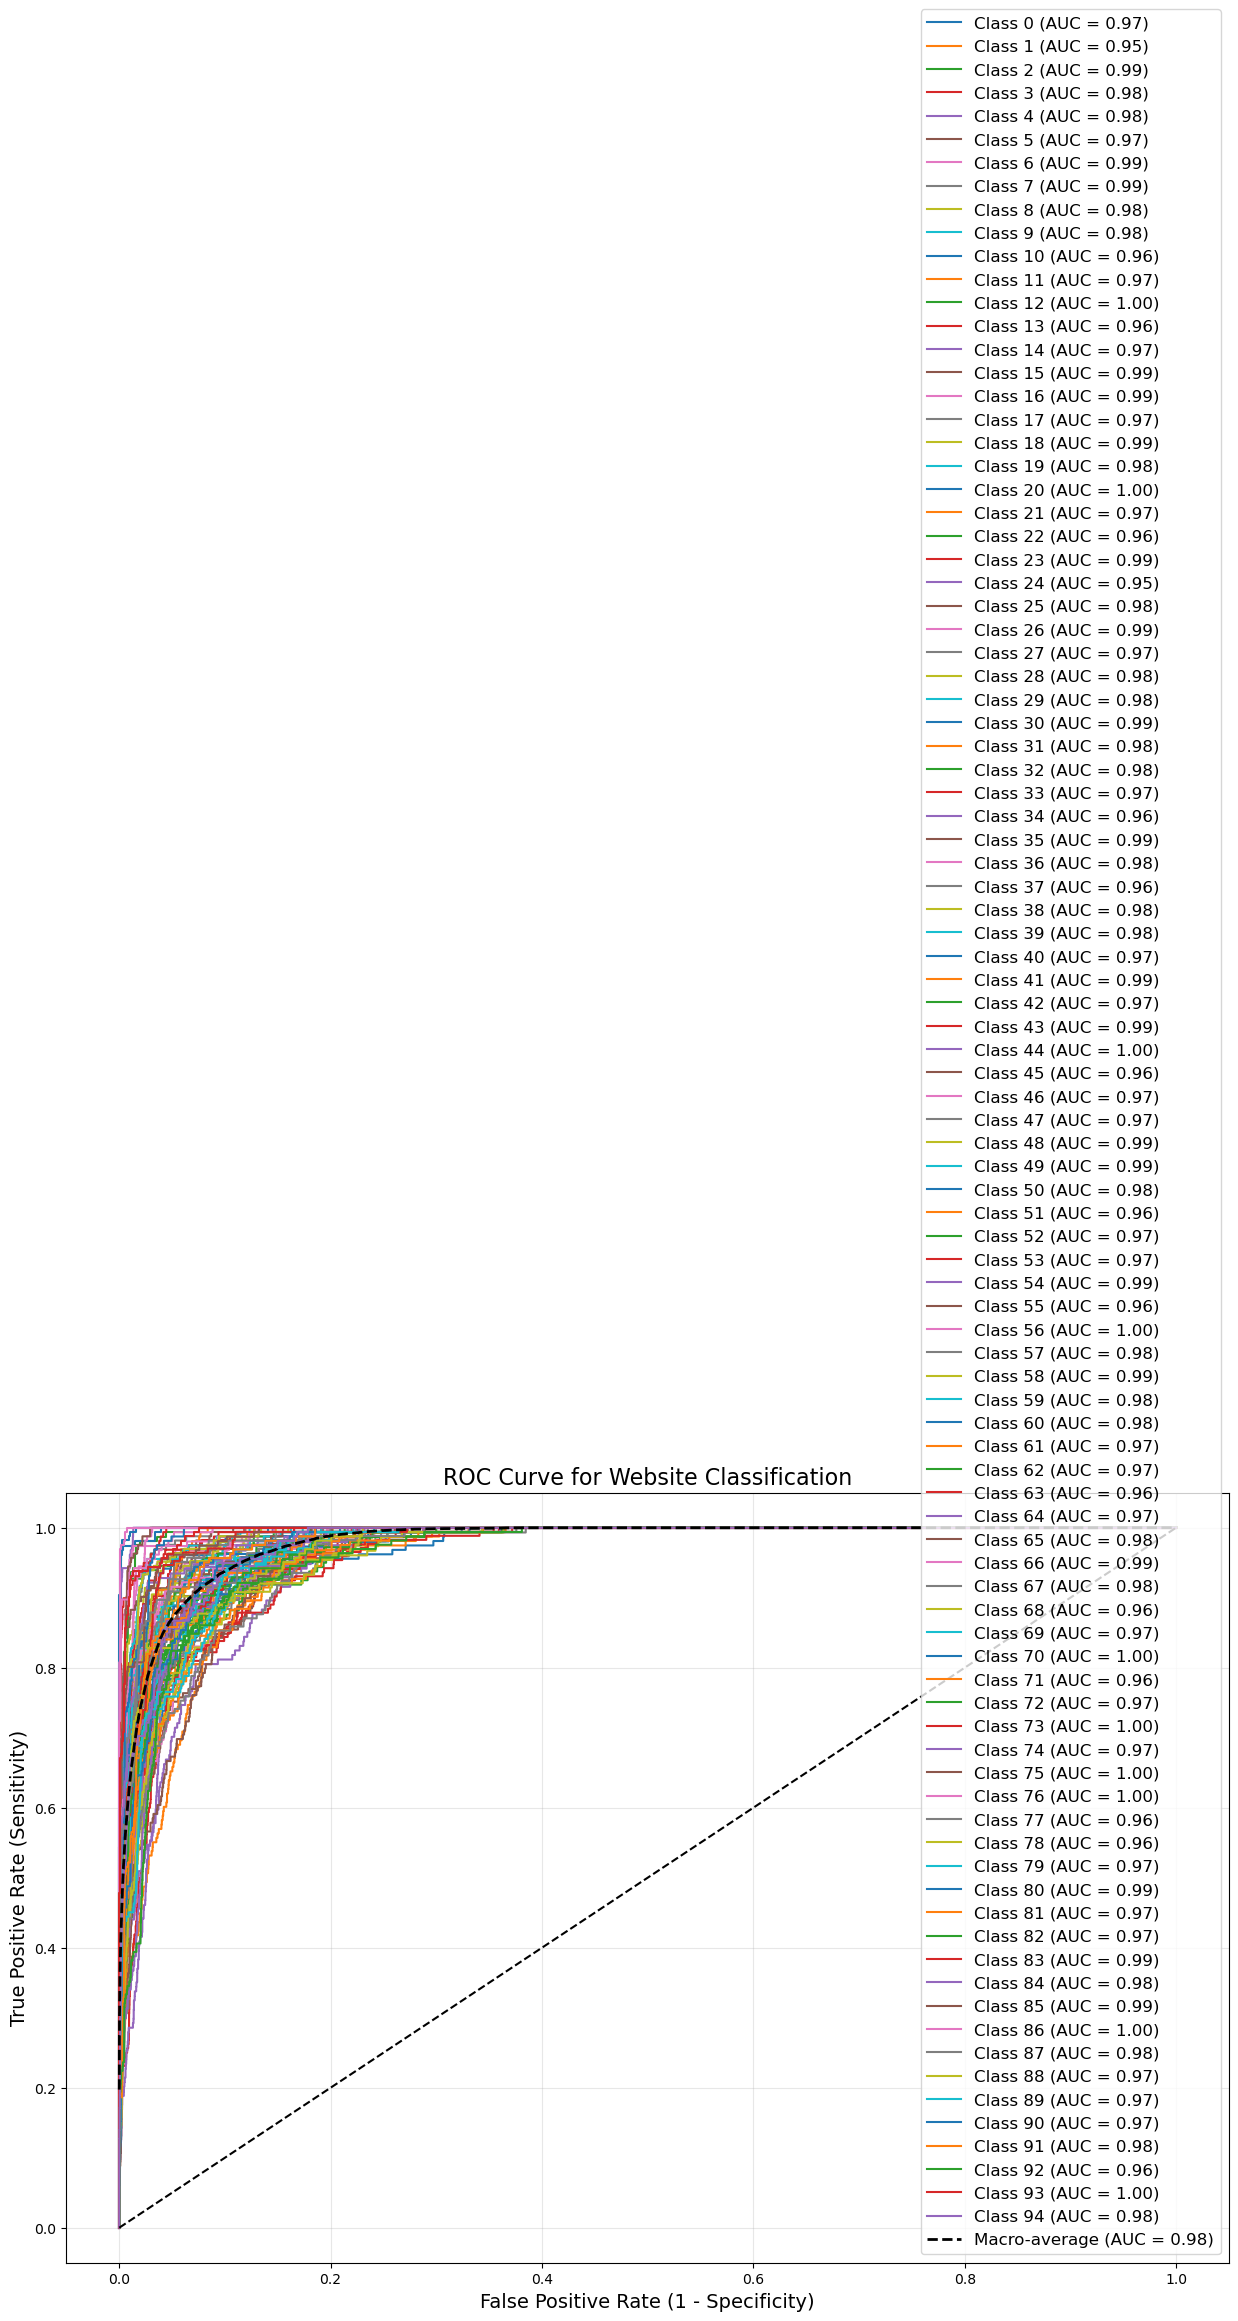

Macro-average AUC: 0.98


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
classes = list(set(y_initial_train))  # Replace with the actual class labels
y_test_bin = label_binarize(y_initial_train, classes=classes)

# Get predicted probabilities
y_pred_proba = clf_all_features.predict_proba(X_initial_train)

# Plot ROC curve
plt.figure(figsize=(15, 10))

# Store individual class ROC curves
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

# Compute ROC curve for each class
for i, class_label in enumerate(classes):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    
    plt.plot(
        fpr_dict[i], tpr_dict[i], 
        label=f'Class {class_label} (AUC = {roc_auc_dict[i]:.2f})'
    )

# Compute Macro Average ROC Curve
# First, create a grid of FPR points
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes))]))

# Interpolate ROC curves
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])

# Average the TPR
mean_tpr /= len(classes)

# Compute macro-average AUC
macro_roc_auc = auc(all_fpr, mean_tpr)

# Plot macro-average ROC curve
plt.plot(
    all_fpr, mean_tpr, 
    color='black', 
    linestyle='--', 
    linewidth=2, 
    label=f'Macro-average (AUC = {macro_roc_auc:.2f})'
)

# Add plot details
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve for Website Classification', fontsize=16)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Optional: Print macro-average AUC
print(f"Macro-average AUC: {macro_roc_auc:.2f}")

# Feature Importance

In [17]:
df_X = pd.DataFrame(X_initial_train)

In [18]:
df_X.head()

,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
6787,5595,798,6393,0.875176,0.124824,1667.233686,3442.906015,49.43,0.007732
6097,9586,392,9978,0.960714,0.039286,3032.469878,4233.829082,20.00,0.002004
11219,3327,156,3483,0.955211,0.044789,1080.035278,1165.185897,12.92,0.003709
2512,1744,80,1824,0.956140,0.043860,585.855395,675.262500,5.35,0.002933
4279,9150,786,9936,0.920894,0.079106,3260.813245,5420.637405,21.67,0.002181


In [19]:
# using entropy
model_1= RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_1.fit(X_initial_train, y_initial_train)
feature_imp_1 = pd.Series(model_1.feature_importances_, index=df_X.columns)

In [20]:
# using gini
model_2= RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_2.fit(X_initial_train, y_initial_train)
feature_imp_2 = pd.Series(model_2.feature_importances_, index=df_X.columns)

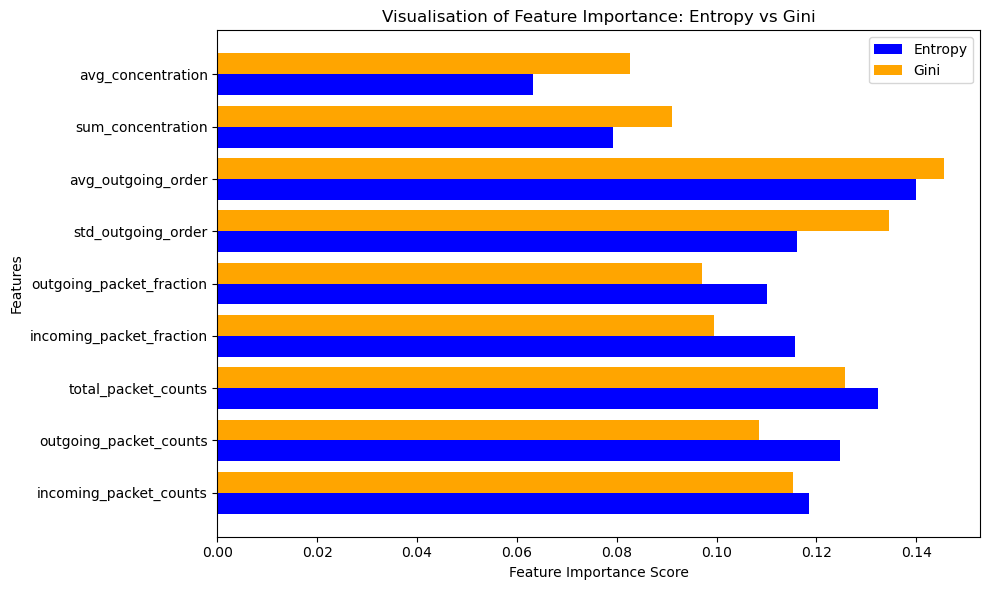

In [21]:
feature_names = df_X.columns
entropy_values = feature_imp_1.values
gini_values = feature_imp_2.values

bar_width = 0.4 
y_positions = range(len(feature_names)) 

plt.figure(figsize=(10,6))

#plotting entropy importance
plt.barh(
    [y - bar_width / 2 for y in y_positions],
    entropy_values,
    bar_width,
    label='Entropy',
    color='blue',
)

# plotting gini improtance
plt.barh(
    [y + bar_width / 2 for y in y_positions],
    gini_values,
    bar_width,
    label='Gini',
    color='orange',
)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.yticks(y_positions, feature_names) 
plt.title('Visualisation of Feature Importance: Entropy vs Gini')
plt.legend()
plt.tight_layout()
plt.show()

Recall the extracted features:
> **Feature Group 1: Traffic Volume (Absolute)**  
> - Feature 1: Number of incoming packets  
> - Feature 2: Number of outgoing packets  
> - Feature 3: Total number of packets  
> 
> **Feature Group 2: Traffic Volume (Fraction)**
> - Feature 1: Number of incoming packets as a fraction of the total number of packets  
> - Feature 2: Number of outgoing packets as a fraction of the total number of packets 
> 
> **Feature Group 3: Traffic Ordering List**
> - Feature 6: Standard deviation of the outgoing packets ordering list  
> - Feature 7: Average of the outgoing packets ordering list  
> 
> **Feature Group 4: Traffic concentration** 
> - Feature 8: Sum of all items in the alternative concentration feature list  
> - Feature 9: Average of all items in the alternative concentration feature list  

We noted that within each of the 4 feature groups, the features are likely to be highly correlated due to their similarity. Furthermore, feature groups 1 and 2 are closely related as well with 1 being an absolute measurement of traffic volume and 2 as the ratio. Hence we will be selecting 2 features from the combination of group 1 and 2, and 1 feature each from group 3 and 4.

According to our feature importance analysis, we have selected the features to be
1. Feature 2: Number of outgoing packets   
2. Feature 3: Total number of packets
3. Feature 7: Average of the outgoing packets ordering list 
4. Feature 8: Sum of all items in the alternative concentration feature list  

In [22]:
X = closed_world_df[['outgoing_packet_counts', 'total_packet_counts', 'avg_outgoing_order', 'sum_concentration']]
y = closed_world_df['label']

# Constructing Model with selected features

In this section, we construct an arbitrary random forest classification model using arbitrarily chosen parameters. This section aims to explore the implementation of the model. These parameters will be tuned in the next section. 

In [23]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [24]:
df = pd.DataFrame(X_train)

In [25]:
df.head()

,outgoing_packet_counts,total_packet_counts,avg_outgoing_order,sum_concentration
6787,798,6393,3442.906015,49.43
6097,392,9978,4233.829082,20.00
11219,156,3483,1165.185897,12.92
2512,80,1824,675.262500,5.35
4279,786,9936,5420.637405,21.67


In [26]:
# Initialize the model
clf_selected_features = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=7, min_samples_split=2, max_features="sqrt", random_state=42)

# Train the model
clf_selected_features.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=42)

In [27]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start memory
memory_before = process.memory_info().rss / (1024 * 1024)
# tracking start time
start_time = time.time()
# Make predictions on the train set
y_train_pred = clf_selected_features.predict(X_train)
# tracking end time
end_time = time.time()
# tracking end memory
memory_after = process.memory_info().rss / (1024 * 1024)

time_taken_selected_features_train = end_time - start_time
memory_used_selected_features_train = memory_after - memory_before

In [28]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_train, "MB")
print("Time taken to predict:", time_taken_selected_features_train, "seconds")
print("Model Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Memory used: 0.30078125 MB
Time taken to predict: 0.5612144470214844 seconds
Model Accuracy: 0.48098684210526316
              precision    recall  f1-score   support

           0       0.65      0.22      0.33       158
           1       1.00      0.03      0.06       158
           2       0.55      0.73      0.63       165
           3       0.61      0.50      0.55       171
           4       0.48      0.30      0.37       161
           5       0.57      0.35      0.44       155
           6       0.36      0.87      0.51       156
           7       0.44      0.48      0.46       164
           8       0.62      0.36      0.46       166
           9       0.28      0.52      0.36       169
          10       0.38      0.29      0.33       153
          11       0.32      0.32      0.32       165
          12       0.63      0.78      0.70       158
          13       0.80      0.10      0.18       160
          14       0.65      0.37      0.47       164
          15       0.4

In [29]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_test_pred = clf_selected_features.predict(X_test)
# tracking end time
end_time = time.time()

time_taken_selected_features_test = end_time - start_time
memory_used_selected_features_test = process.memory_info().rss / (1024 * 1024)

In [30]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_test, "MB")
print("Time taken to predict:", time_taken_selected_features_test, "seconds")
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Memory used: 1438.0859375 MB
Time taken to predict: 0.1302950382232666 seconds
Model Accuracy: 0.43342105263157893
              precision    recall  f1-score   support

           0       0.78      0.17      0.27        42
           1       0.00      0.00      0.00        42
           2       0.35      0.74      0.48        35
           3       0.39      0.38      0.39        29
           4       0.59      0.41      0.48        39
           5       0.48      0.24      0.32        45
           6       0.34      0.77      0.48        44
           7       0.28      0.31      0.29        36
           8       0.45      0.29      0.36        34
           9       0.16      0.45      0.24        31
          10       0.38      0.28      0.32        47
          11       0.32      0.40      0.35        35
          12       0.62      0.71      0.67        42
          13       0.33      0.03      0.05        40
          14       0.64      0.19      0.30        36
          15       0

c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jo-ne\miniconda3\envs\dl_lab\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Model Tuning

In this section, we will be using Grid Search to tune our model parameters for our Random Forest Classifier

In [ ]:
# I was able to get another 1% on the testing accuracy by using this param grid vs the other we were using

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Refined parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'], 
    'class_weight': [None, 'balanced'],
    'bootstrap': [True],
}

# Defining the grid search
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,  
    refit=True, 
    verbose=3,
    n_jobs=-1,
    scoring='balanced_accuracy'
)

In [ ]:
# this is the model we are using in other tests (gives less accuracy)

# Defining the parameter grid for the Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']           
}

# Defining the grid search
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,  
    refit=True, 
    verbose = 3,
    n_jobs=-1
)

In [ ]:
# Fitting the grid search
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
time_taken_grid_search = end_time - start_time

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
# Print the time taken to perform the grid search
print("Time taken for grid search:", time_taken_grid_search, "seconds")

In [ ]:
# Print best parameters after grid search
print("Best parameters found:", grid.best_params_)

In [ ]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_train_pred = grid.predict(X_train)
# tracking end time
end_time = time.time()

time_taken_selected_features_tuned_train = end_time - start_time
memory_used_selected_features_tuned_train = process.memory_info().rss / (1024 * 1024)

In [ ]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_tuned_train, "MB")
print("Time taken to predict:", time_taken_selected_features_tuned_train, "seconds")
print("Model Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

In [ ]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_test_pred = grid.predict(X_test)
# tracking end time
end_time = time.time()

time_taken_selected_features_tuned_test = end_time - start_time
memory_used_selected_features_tuned_test = process.memory_info().rss / (1024 * 1024)

In [ ]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_tuned_test, "MB")
print("Time taken to predict:", time_taken_selected_features_tuned_test, "seconds")
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the test labels
classes = clf_selected_features.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities
y_test_proba = clf_selected_features.predict_proba(X_test)

# Function to smooth the ROC curve
def smooth_curve(x, y, num_points=1000):
    # Ensure unique x values
    unique_x, indices = np.unique(x, return_index=True)
    unique_y = y[indices]
    
    # Interpolate
    f = interp1d(unique_x, unique_y, kind='quadratic', fill_value="extrapolate")
    x_new = np.linspace(0, 1, num_points)
    y_new = f(x_new)
    
    return x_new, y_new

# Plot ROC curve with smoothing
plt.figure(figsize=(12, 8))
roc_aucs = []

# Compute ROC for each class
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Smooth the curve
    fpr_smooth, tpr_smooth = smooth_curve(fpr, tpr)
    
    # Store for macro-average calculation
    roc_aucs.append((class_label, roc_auc, fpr_smooth, tpr_smooth))
    
    # Plot smoothed curve for each class
    plt.plot(fpr_smooth, tpr_smooth, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

# Macro-average ROC curve
try:
    # Prepare for macro-average
    all_fpr = np.unique(np.concatenate([roc[2] for roc in roc_aucs]))
    mean_tpr = np.zeros_like(all_fpr)
    
    # Interpolate and average TPR
    for _, _, fpr, tpr in roc_aucs:
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= len(roc_aucs)
    
    # Compute macro-average AUC
    macro_auc = auc(all_fpr, mean_tpr)
    
    # Plot macro-average ROC curve
    plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {macro_auc:.2f})', 
             color='black', linestyle='--', linewidth=2)
except Exception as e:
    print(f"Error computing macro-average: {e}")

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize the plot
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Smoothed Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()